# Note: This notebook was generated by ChatGPT 4o 
### Shortcomings:
It currently models only the ascendinng data, although both ascending and descending data are shown. The python is not very good, so I did not bother  modifying it. Need to try the same prompt with a newer large language model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import pi
from scipy.fftpack import fft2, ifft2

# Enable inline plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['font.size'] = 12

In [2]:
# ==============================================
# PARAMETERS (adjust as needed)
# ==============================================

# Inversion model type (for future extension, e.g., 'Mogi', 'Penny', 'Yang')
inversion_model = 'Mogi'

# Synthetic grid: horizontal from -5000 to 5000 m with 50 m spacing
grid_min = -5000
grid_max = 5000
grid_spacing = 50

# Noise parameters for power-law noise
noise_exponent = 2.0
noise_amplitude = 0.02  # in meters

# Downsample factor (e.g., 10: 50 m grid -> 500 m grid)
downsample_factor = 10

# True parameters for the two-source model:
# Source 1: center (0,0), depth = 1000 m, dV chosen to yield 20 cm uplift above the source
true1 = {'x': 0.0, 'y': 0.0, 'z': 1000.0}
nu = 0.25
dV_true = 0.20 * pi * true1['z']**2 / (1 - nu)  # calibrates for 20 cm uplift at r=0

# Source 2: 2 km to the east, depth = 700 m
true2 = {'x': 2000.0, 'y': 0.0, 'z': 700.0}
dV_true2 = 0.20 * pi * true2['z']**2 / (1 - nu)

# Radar incidence angle (degrees)
inc_angle_deg = 40

# Inversion domain for nonlinear parameters (for each source):
domain = {
    'x': (-4000, 4000),
    'y': (-4000, 4000),
    'z': (200, 1800)
}

# Monte Carlo sample count for inversion
mc_samples = 1000

print('Inversion model:', inversion_model)
print('Synthetic grid: from', grid_min, 'to', grid_max, 'with spacing', grid_spacing, 'm')
print('Noise: exponent =', noise_exponent, ', amplitude =', noise_amplitude, 'm')
print('Downsample factor:', downsample_factor)
print('Inversion domain: x,y =', domain['x'], 'and z =', domain['z'])

Inversion model: Mogi
Synthetic grid: from -5000 to 5000 with spacing 50 m
Noise: exponent = 2.0 , amplitude = 0.02 m
Downsample factor: 10
Inversion domain: x,y = (-4000, 4000) and z = (200, 1800)


## 1. Synthetic Data Generation

We define a function for the Mogi source displacements. The Mogi solution gives the vertical displacement at an observation point $(x, y)$ due to a point source at $(x_0, y_0, z_0)$ with volume change $\Delta V$:

$$
u_z = \frac{(1 - \nu) \Delta V}{\pi} \cdot \frac{z_0}{(r^2 + z_0^2)^{3/2}}, \quad \text{where} \quad r = \sqrt{(x - x_0)^2 + (y - y_0)^2}
$$

The eastward (horizontal) displacement is computed similarly using the same denominator and radial geometry but with an appropriate horizontal projection of the source.

We generate synthetic data for our two‑source model by computing the contributions from Source 1 and Source 2, and summing them.

In [3]:
def mogi_displacement(x_obs, y_obs, x0, y0, z0, dV, nu=0.25):
    """Compute vertical (u_z) and eastward (u_E) displacements at (x_obs, y_obs) for a Mogi source."""
    dx = x_obs - x0
    dy = y_obs - y0
    r = np.sqrt(dx**2 + dy**2)
    R = np.sqrt(r**2 + z0**2)
    uz = (1 - nu) * dV / pi * (z0 / R**3)
    ur = (1 - nu) * dV / pi * (r / R**3)
    uE = np.zeros_like(ur)
    nonzero = (r > 1e-10)
    uE[nonzero] = ur[nonzero] * (dx[nonzero] / r[nonzero])
    return uz, uE

# Create a 10 km x 10 km grid with 50 m spacing
x = np.arange(grid_min, grid_max + grid_spacing, grid_spacing)
y = np.arange(grid_min, grid_max + grid_spacing, grid_spacing)
X, Y = np.meshgrid(x, y)

# Compute displacements for each source
Uz1, uE1 = mogi_displacement(X, Y, true1['x'], true1['y'], true1['z'], dV_true, nu)
Uz2, uE2 = mogi_displacement(X, Y, true2['x'], true2['y'], true2['z'], dV_true2, nu)

# Total displacements (sum contributions from both sources)
Uz_total = Uz1 + Uz2
uE_total = uE1 + uE2


## 2. Convert to Radar LOS and Plot Clean Data

We convert the vertical and eastward displacements to radar line‑of‑sight (LOS) for both ascending and descending geometries. For a radar incidence angle of 40°:

- **Ascending:** \( \text{LOS} = -u_z\cos(inc) + u_E\sin(inc) \)
- **Descending:** \( \text{LOS} = -u_z\cos(inc) - u_E\sin(inc) \)

The clean synthetic data are then plotted.

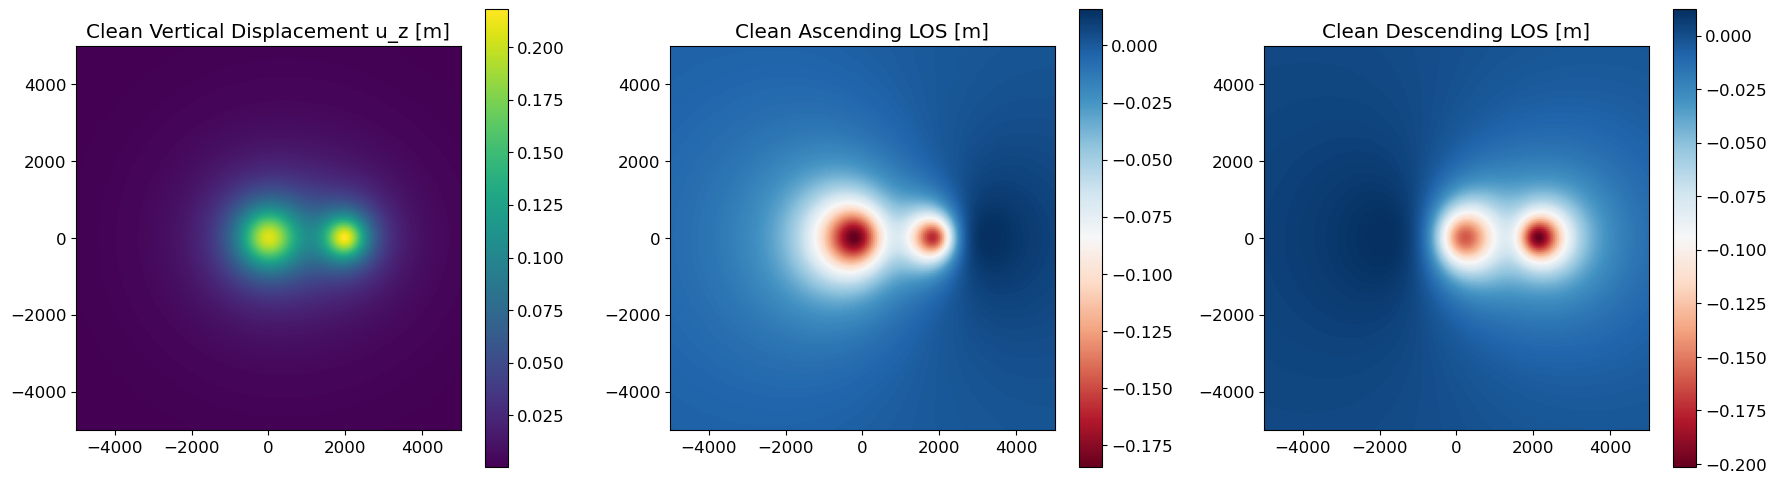

In [4]:
inc = np.deg2rad(inc_angle_deg)
LOS_asc = -Uz_total * np.cos(inc) + uE_total * np.sin(inc)
LOS_desc = -Uz_total * np.cos(inc) - uE_total * np.sin(inc)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
im0 = ax[0].imshow(Uz_total, cmap='viridis', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
ax[0].set_title('Clean Vertical Displacement u_z [m]')
fig.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(LOS_asc, cmap='RdBu', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
ax[1].set_title('Clean Ascending LOS [m]')
fig.colorbar(im1, ax=ax[1])

im2 = ax[2].imshow(LOS_desc, cmap='RdBu', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
ax[2].set_title('Clean Descending LOS [m]')
fig.colorbar(im2, ax=ax[2])
plt.tight_layout()
plt.show()

## 3. Add Noise Using a Power-Law Noise Model

We add noise to the LOS fields using a 2D power‑law noise model. The noise parameters (spectral exponent and amplitude) are adjustable. The noisy LOS data are then plotted.

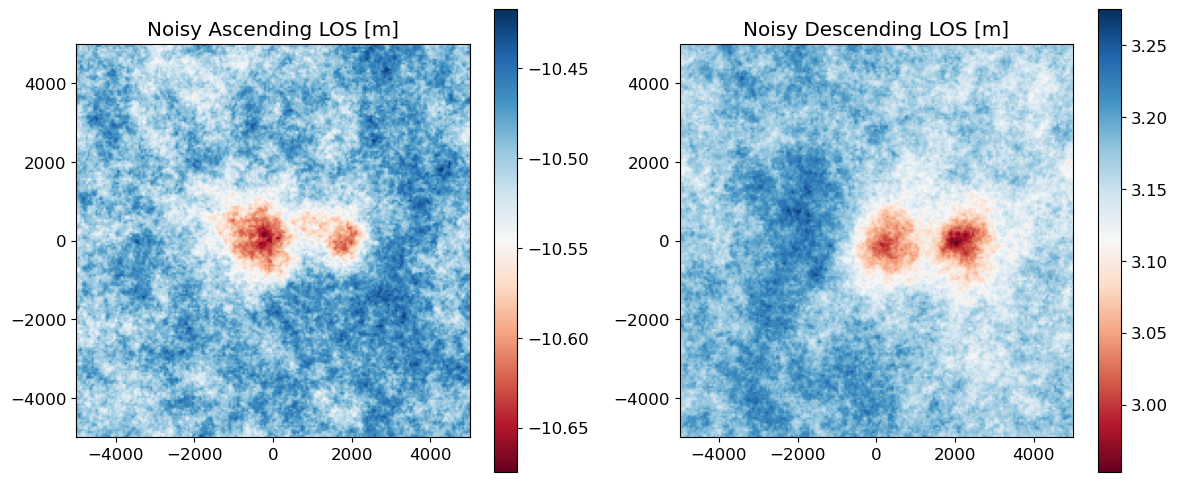

In [5]:
def power_law_noise(shape, exponent=2.0, amplitude=0.02):
    noise = np.random.randn(*shape)
    f_noise = fft2(noise)
    fx = np.fft.fftfreq(shape[0])
    fy = np.fft.fftfreq(shape[1])
    FX, FY = np.meshgrid(fx, fy, indexing='ij')
    radius = np.sqrt(FX**2 + FY**2)
    radius[0, 0] = 1e-6
    f_noise = f_noise / radius**(exponent/2)
    noise = np.real(ifft2(f_noise))
    noise = amplitude * noise / np.std(noise)
    return noise

LOS_asc_noisy = LOS_asc + power_law_noise(LOS_asc.shape, exponent=noise_exponent, amplitude=noise_amplitude)
LOS_desc_noisy = LOS_desc + power_law_noise(LOS_desc.shape, exponent=noise_exponent, amplitude=noise_amplitude)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im0 = ax[0].imshow(LOS_asc_noisy, cmap='RdBu', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
ax[0].set_title('Noisy Ascending LOS [m]')
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(LOS_desc_noisy, cmap='RdBu', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
ax[1].set_title('Noisy Descending LOS [m]')
fig.colorbar(im1, ax=ax[1])
plt.tight_layout()
plt.show()

## 4. Downsample Data

We downsample the noisy interferograms from the original 50 m grid to a 500 m grid by taking every 10th sample. The downsampled data are plotted using nearest‑neighbor interpolation so that each data point is displayed as a square with no white space.

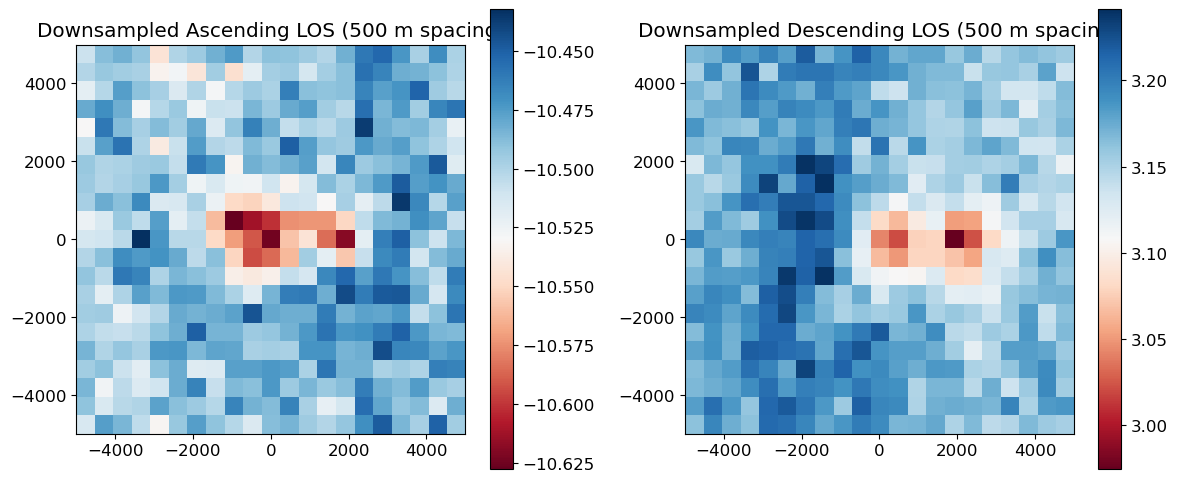

In [6]:
step = downsample_factor  # 10
X_ds = X[::step, ::step]
Y_ds = Y[::step, ::step]
asc_ds = LOS_asc_noisy[::step, ::step]
desc_ds = LOS_desc_noisy[::step, ::step]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im0 = ax[0].imshow(asc_ds, cmap='RdBu', extent=[X_ds.min(), X_ds.max(), Y_ds.min(), Y_ds.max()], origin='lower', interpolation='nearest')
ax[0].set_title('Downsampled Ascending LOS (500 m spacing)')
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(desc_ds, cmap='RdBu', extent=[X_ds.min(), X_ds.max(), Y_ds.min(), Y_ds.max()], origin='lower', interpolation='nearest')
ax[1].set_title('Downsampled Descending LOS (500 m spacing)')
fig.colorbar(im1, ax=ax[1])
plt.tight_layout()
plt.show()

## 5. Inversion Using Monte Carlo Approaches (Two-Source Inversion Model)

We now invert the noisy, downsampled synthetic data using a two‑source inversion model. In this inversion the nonlinear parameters are
$$
\mathbf{m} = [x_1,\,y_1,\,z_1,\,x_2,\,y_2,\,z_2]
$$
For each candidate model we perform a linear inversion for the source strengths (dV₁ and dV₂) using least squares (i.e. solve \( A\,dV = d \) with \( A = [F_1, F_2] \)). The misfit is computed as the sum of squared residuals between the observed downsampled ascending LOS and the predicted LOS.

We first perform an **undirected Monte Carlo inversion** where the candidate parameters are drawn uniformly from the inversion domain (for each parameter: x and y ∈ [-4000,4000] m and z ∈ [200,1800] m). For each candidate we store the candidate parameters, the computed dV values, and the misfit. For each candidate depth (here we can later bin by z₁ if desired) the best candidate is printed and then the overall best-fitting model is printed. Finally, using the best-fitting model we plot the downsampled data, the predicted LOS, and the residuals for both ascending and descending data.

Undirected Monte Carlo best two-source inversion:
Source 1: (x,y,z) = (3692.1, 1820.2, 1575.1 m), dV = 2.975e+08
Source 2: (x,y,z) = (3837.1, -2014.5, 1579.5 m), dV = 2.955e+08
Misfit = 2.346e+04


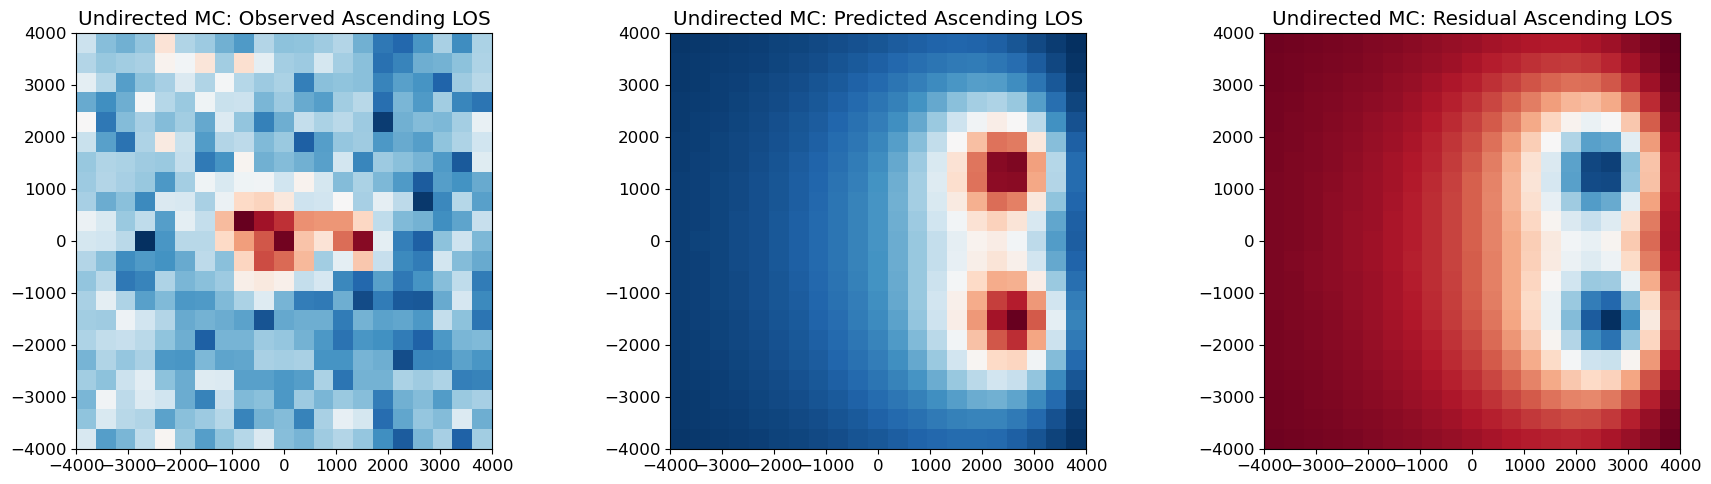

In [7]:
# ------------------------------
# 5.1 Undirected Monte Carlo Inversion
# ------------------------------

# Observed data (from downsampled ascending LOS)
obs_x = X_ds.flatten()
obs_y = Y_ds.flatten()
obs_data = asc_ds.flatten()

samples = mc_samples
# For source 1
mc_x1 = np.random.uniform(domain['x'][0], domain['x'][1], samples)
mc_y1 = np.random.uniform(domain['y'][0], domain['y'][1], samples)
mc_z1 = np.random.uniform(domain['z'][0], domain['z'][1], samples)
# For source 2
mc_x2 = np.random.uniform(domain['x'][0], domain['x'][1], samples)
mc_y2 = np.random.uniform(domain['y'][0], domain['y'][1], samples)
mc_z2 = np.random.uniform(domain['z'][0], domain['z'][1], samples)

# Arrays to store inversion results
misfit_mc = np.zeros(samples)
dV1_mc = np.zeros(samples)
dV2_mc = np.zeros(samples)

def two_source_forward(obs_x, obs_y, params, nu=0.25):
    """Compute combined unit LOS responses for two sources given parameters: [x1,y1,z1,x2,y2,z2]."""
    x1, y1, z1, x2, y2, z2 = params
    uz1, ux1 = mogi_displacement(obs_x, obs_y, x1, y1, z1, 1.0, nu)
    uz2, ux2 = mogi_displacement(obs_x, obs_y, x2, y2, z2, 1.0, nu)
    F1 = -uz1 * np.cos(inc) + ux1 * np.sin(inc)
    F2 = -uz2 * np.cos(inc) + ux2 * np.sin(inc)
    return F1, F2

for i in range(samples):
    params = [mc_x1[i], mc_y1[i], mc_z1[i], mc_x2[i], mc_y2[i], mc_z2[i]]
    F1, F2 = two_source_forward(obs_x, obs_y, params, nu)
    A = np.vstack([F1, F2]).T
    sol, _, _, _ = np.linalg.lstsq(A, obs_data, rcond=None)
    dV1_mc[i] = sol[0]
    dV2_mc[i] = sol[1]
    model_pred = sol[0]*F1 + sol[1]*F2
    misfit_mc[i] = np.sum((obs_data - model_pred)**2)

best_idx_mc = np.argmin(misfit_mc)
best_params_mc = np.array([mc_x1[best_idx_mc], mc_y1[best_idx_mc], mc_z1[best_idx_mc],
                            mc_x2[best_idx_mc], mc_y2[best_idx_mc], mc_z2[best_idx_mc]])
best_dV_mc = np.array([dV1_mc[best_idx_mc], dV2_mc[best_idx_mc]])

print("Undirected Monte Carlo best two-source inversion:")
print(f"Source 1: (x,y,z) = ({best_params_mc[0]:.1f}, {best_params_mc[1]:.1f}, {best_params_mc[2]:.1f} m), dV = {best_dV_mc[0]:.3e}")
print(f"Source 2: (x,y,z) = ({best_params_mc[3]:.1f}, {best_params_mc[4]:.1f}, {best_params_mc[5]:.1f} m), dV = {best_dV_mc[1]:.3e}")
print(f"Misfit = {misfit_mc[best_idx_mc]:.3e}")

# Using the best undirected model, compute predictions and residuals for both ascending and descending LOS
def compute_model(obs_x, obs_y, params, dV, nu=0.25):
    F1, F2 = two_source_forward(obs_x, obs_y, params, nu)
    return dV[0]*F1 + dV[1]*F2

pred_asc_mc = compute_model(obs_x, obs_y, best_params_mc, best_dV_mc, nu)
res_asc_mc = obs_data - pred_asc_mc

# Reshape for plotting (using downsampled grid shape)
pred_asc_mc_grid = pred_asc_mc.reshape(asc_ds.shape)
res_asc_mc_grid = res_asc_mc.reshape(asc_ds.shape)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
im0 = ax[0].imshow(asc_ds, cmap='RdBu', extent=[-4000,4000,-4000,4000], origin='lower', interpolation='nearest')
ax[0].set_title('Undirected MC: Observed Ascending LOS')
im1 = ax[1].imshow(pred_asc_mc_grid, cmap='RdBu', extent=[-4000,4000,-4000,4000], origin='lower', interpolation='nearest')
ax[1].set_title('Undirected MC: Predicted Ascending LOS')
im2 = ax[2].imshow(res_asc_mc_grid, cmap='RdBu', extent=[-4000,4000,-4000,4000], origin='lower', interpolation='nearest')
ax[2].set_title('Undirected MC: Residual Ascending LOS')
plt.tight_layout()
plt.show()

# Also plot the covariance and marginal distributions for the candidate nonlinear parameters
params_mc = np.column_stack((mc_x1, mc_y1, mc_z1, mc_x2, mc_y2, mc_z2))


## 6. Plot Covariance and Marginal Distributions

The following helper function creates a typical corner-plot (triangular layout) showing the marginal distributions (on the diagonal) and pairwise scatter (covariance) plots (in the lower triangle). The axes are set to the entire inversion domain. The function accepts a list of parameter names so that it can work with any number of parameters (to facilitate later model changes).

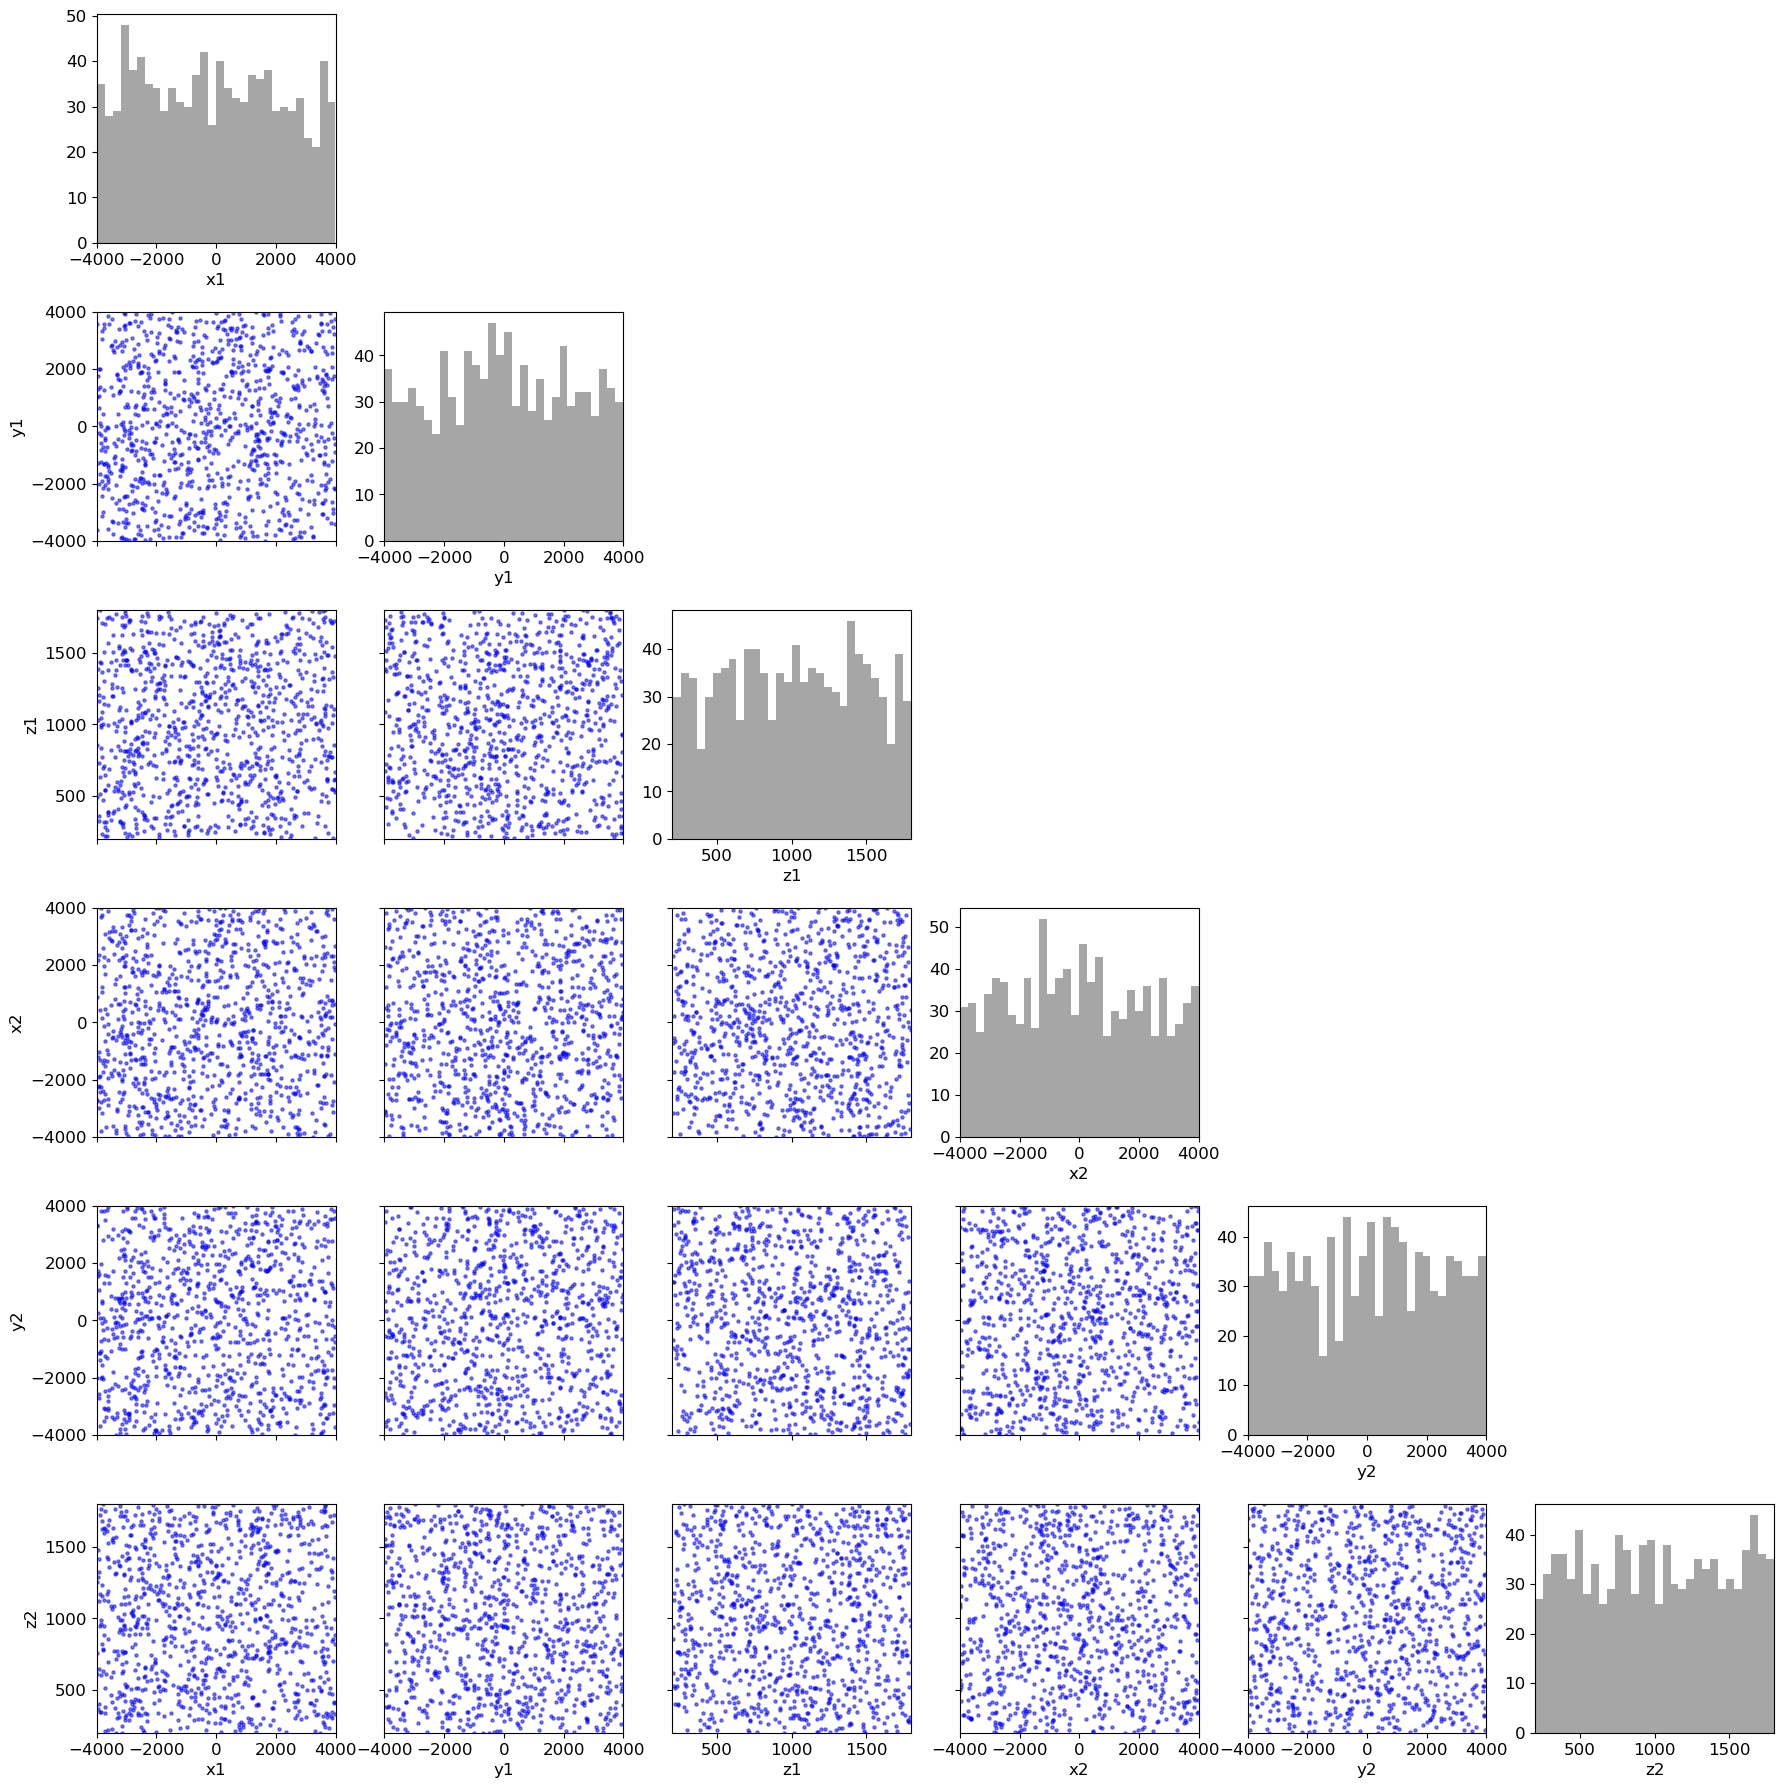

In [8]:
def plot_covariance_marginal_distributions(samples, param_names):
    """Create a corner plot with histograms on the diagonal and scatter plots in the lower triangle. Axes limits are set to the full inversion domain."""
    import matplotlib.gridspec as gridspec
    samples = np.atleast_2d(samples)  # shape (N, d)
    N, d = samples.shape
    
    # Define axis limits based on domain for each parameter
    # Assume the same limits for x and y and for z as provided in 'domain'.
    axis_limits = []
    for name in param_names:
        if name in ['x1','x2','y1','y2']:
            axis_limits.append(domain['x'])
        elif name in ['z1','z2','z']:
            axis_limits.append(domain['z'])
        else:
            axis_limits.append((np.min(samples[:, param_names.index(name)]), np.max(samples[:, param_names.index(name)])))
    
    fig = plt.figure(figsize=(3*d, 3*d))
    gs = gridspec.GridSpec(d, d)
    for i in range(d):
        for j in range(d):
            ax = plt.subplot(gs[i, j])
            if i == j:
                ax.hist(samples[:, i], bins=30, color='gray', alpha=0.7)
                ax.set_xlabel(param_names[i])
                ax.set_xlim(axis_limits[i])
            elif i > j:
                ax.scatter(samples[:, j], samples[:, i], s=5, color='blue', alpha=0.5)
                ax.set_xlim(axis_limits[j])
                ax.set_ylim(axis_limits[i])
                if j == 0:
                    ax.set_ylabel(param_names[i])
                else:
                    ax.set_yticklabels([])
                if i == d-1:
                    ax.set_xlabel(param_names[j])
                else:
                    ax.set_xticklabels([])
            else:
                ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot corner plot for undirected MC candidates
plot_covariance_marginal_distributions(params_mc, ['x1','y1','z1','x2','y2','z2'])


## 7. Directed Monte Carlo Inversion

Now we perform a directed Monte Carlo inversion for the two‑source model. Candidate nonlinear parameters are drawn from a Gaussian proposal centered on the true model \( [0,0,1000, 2000,0,700] \) with standard deviations (500 m for x and y, 200 m for z for each source) and then clipped to the inversion domain. For each candidate a linear inversion for dV is performed and the misfit computed. The overall best model is printed and its predictions (and residuals) are plotted for both ascending and descending LOS. We also plot the candidate parameters with our corner-plot function.

Directed Monte Carlo best two-source inversion:
Source 1: (x,y,z) = (153.5, -297.3, 1117.8 m), dV = 1.399e+08
Source 2: (x,y,z) = (2876.3, -187.5, 1191.5 m), dV = 2.117e+08
Misfit = 3.305e+04


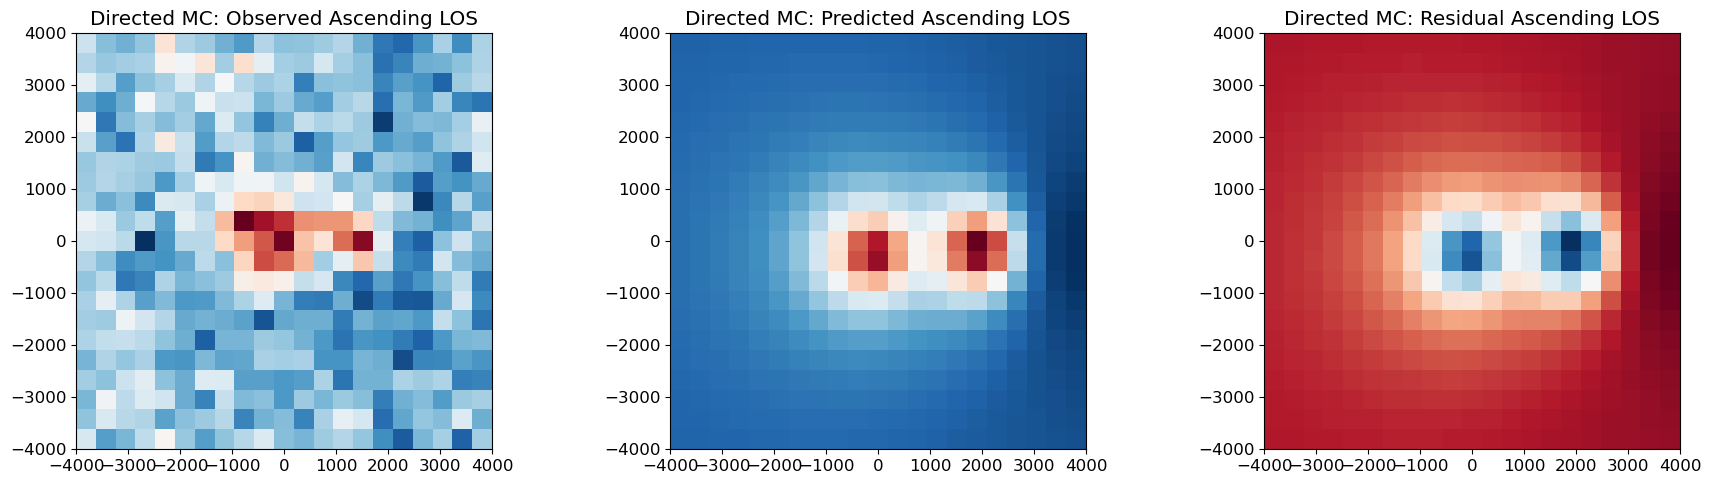

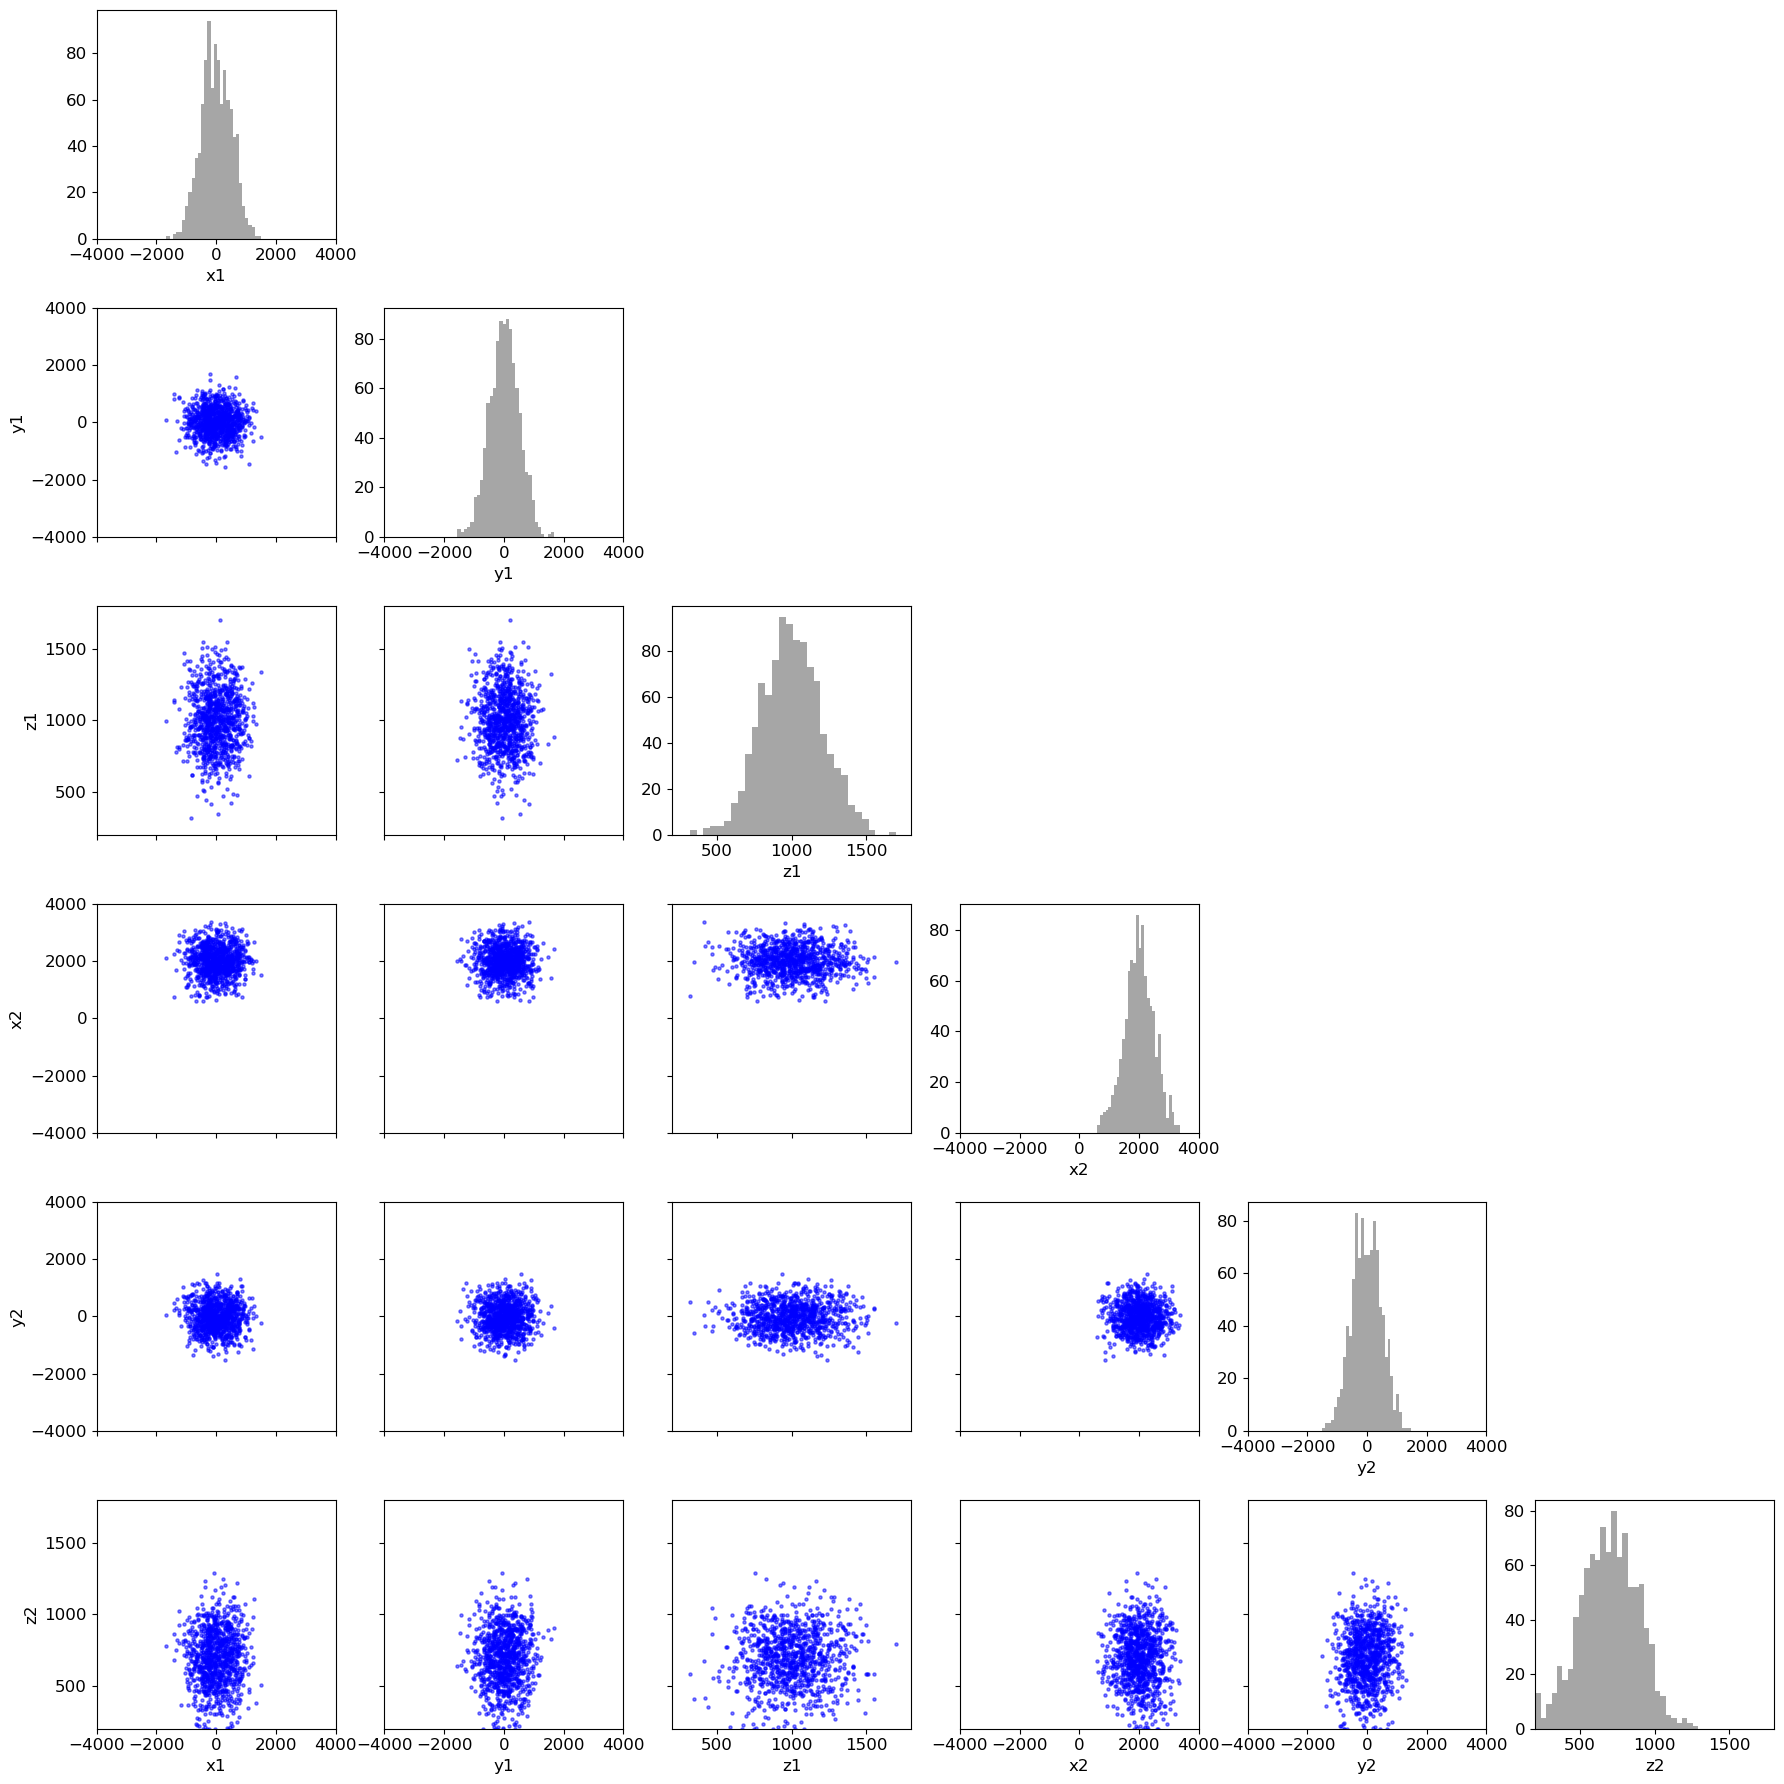

In [9]:
# Directed Monte Carlo Inversion for Two-Source Model
samples = mc_samples

# Draw Gaussian samples for source 1 (centered at true1) and source 2 (centered at true2)
mc_x1_dir = np.clip(np.random.normal(true1['x'], 500, samples), domain['x'][0], domain['x'][1])
mc_y1_dir = np.clip(np.random.normal(true1['y'], 500, samples), domain['y'][0], domain['y'][1])
mc_z1_dir = np.clip(np.random.normal(true1['z'], 200, samples), domain['z'][0], domain['z'][1])

mc_x2_dir = np.clip(np.random.normal(true2['x'], 500, samples), domain['x'][0], domain['x'][1])
mc_y2_dir = np.clip(np.random.normal(true2['y'], 500, samples), domain['y'][0], domain['y'][1])
mc_z2_dir = np.clip(np.random.normal(true2['z'], 200, samples), domain['z'][0], domain['z'][1])

misfit_dir = np.zeros(samples)
dV1_dir = np.zeros(samples)
dV2_dir = np.zeros(samples)

for i in range(samples):
    params = [mc_x1_dir[i], mc_y1_dir[i], mc_z1_dir[i], mc_x2_dir[i], mc_y2_dir[i], mc_z2_dir[i]]
    F1, F2 = two_source_forward(obs_x, obs_y, params, nu)
    A = np.vstack([F1, F2]).T
    sol, _, _, _ = np.linalg.lstsq(A, obs_data, rcond=None)
    dV1_dir[i] = sol[0]
    dV2_dir[i] = sol[1]
    model_pred = sol[0]*F1 + sol[1]*F2
    misfit_dir[i] = np.sum((obs_data - model_pred)**2)

best_idx_dir = np.argmin(misfit_dir)
best_params_dir = np.array([mc_x1_dir[best_idx_dir], mc_y1_dir[best_idx_dir], mc_z1_dir[best_idx_dir],
                             mc_x2_dir[best_idx_dir], mc_y2_dir[best_idx_dir], mc_z2_dir[best_idx_dir]])
best_dV_dir = np.array([dV1_dir[best_idx_dir], dV2_dir[best_idx_dir]])

print("Directed Monte Carlo best two-source inversion:")
print(f"Source 1: (x,y,z) = ({best_params_dir[0]:.1f}, {best_params_dir[1]:.1f}, {best_params_dir[2]:.1f} m), dV = {best_dV_dir[0]:.3e}")
print(f"Source 2: (x,y,z) = ({best_params_dir[3]:.1f}, {best_params_dir[4]:.1f}, {best_params_dir[5]:.1f} m), dV = {best_dV_dir[1]:.3e}")
print(f"Misfit = {misfit_dir[best_idx_dir]:.3e}")

# Compute predictions and residuals for best directed model for both ascending and descending LOS
pred_asc_dir = compute_model(obs_x, obs_y, best_params_dir, best_dV_dir, nu)
res_asc_dir = obs_data - pred_asc_dir

pred_asc_dir_grid = pred_asc_dir.reshape(asc_ds.shape)
res_asc_dir_grid = res_asc_dir.reshape(asc_ds.shape)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
im0 = ax[0].imshow(asc_ds, cmap='RdBu', extent=[-4000,4000,-4000,4000], origin='lower', interpolation='nearest')
ax[0].set_title('Directed MC: Observed Ascending LOS')
im1 = ax[1].imshow(pred_asc_dir_grid, cmap='RdBu', extent=[-4000,4000,-4000,4000], origin='lower', interpolation='nearest')
ax[1].set_title('Directed MC: Predicted Ascending LOS')
im2 = ax[2].imshow(res_asc_dir_grid, cmap='RdBu', extent=[-4000,4000,-4000,4000], origin='lower', interpolation='nearest')
ax[2].set_title('Directed MC: Residual Ascending LOS')
plt.tight_layout()
plt.show()

# Also plot the covariance and marginal distributions for the candidate nonlinear parameters
params_dir = np.column_stack((mc_x1_dir, mc_y1_dir, mc_z1_dir, mc_x2_dir, mc_y2_dir, mc_z2_dir))
plot_covariance_marginal_distributions(params_dir, ['x1','y1','z1','x2','y2','z2'])


## 10. Summary

This notebook has demonstrated a non‑linear inversion workflow using synthetic InSAR data for active volcanoes. In summary:

- We generated synthetic data for a two‑source Mogi model on a 10 km × 10 km grid (50 m spacing) with:
  - Source 1 at (0,0) with 1 km depth (calibrated for 20 cm uplift above the source),
  - Source 2 at (2000, 0) with 700 m depth.
- The vertical and eastward displacements were converted to radar LOS for both ascending and descending geometries (40° incidence) and the clean data were plotted.
- Noise was added using a 2D power‑law noise model and the noisy data were plotted.
- The noisy data were downsampled (by a factor of 10) so that the 50 m grid becomes a 500 m grid; the downsampled data were plotted with each point shown as a square.
- Inversions were conducted on the downsampled data using undirected and directed Monte Carlo approaches for a two‑source inversion model. For each candidate nonlinear parameter set \( [x_1,y_1,z_1,x_2,y_2,z_2] \) (drawn either uniformly or from a Gaussian proposal), a linear inversion was performed for the source strengths and the misfit computed. The best-fitting model (by misfit) was identified for each method and its predicted LOS and residuals were plotted (for both ascending and descending data).
- A helper function, `plot_covariance_marginal_distributions`, produces a typical triangular corner plot showing the full-candidate marginal distributions and pairwise covariances (with axis limits set to the full inversion domain). This function is written to work for any number of model parameters so that later you can easily extend the inversion model (e.g. to replace a Mogi source with a Penny‑shaped crack or Yang source).

Feel free to adjust any parameters as needed. Happy inverting!